This notebook performs quality checks on the ASL alphabet dataset to ensure all images are usable for further analysis and modeling.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from tqdm import tqdm
from utils.config import load_config

### Load data paths from config

In [6]:
config    = load_config()
train_dir = config['data_paths']['images_raw']
classes   = os.listdir(train_dir)

### Checking for Corrupted Images
* Load each image to check if it is corrupted. 
* Corrupted images will be listed for review and removal if necessary.

In [7]:
def check_corrupted_images(directory):
    corrupted_files = []
    classes = os.listdir(directory)
    for cls in tqdm(classes, total=len(classes), desc="Processing classes"):
        class_dir = os.path.join(directory, cls)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                corrupted_files.append(img_path)
    return corrupted_files

# Check for corrupted images in the training directory
corrupted_images = check_corrupted_images(train_dir)
print("Corrupted images:", corrupted_images)

Processing classes: 100%|██████████| 29/29 [00:32<00:00,  1.14s/it]

Corrupted images: []


There are **No Corrupted Images** in the dataset

### Color Channel Verification

In [12]:

color_modes = []

for cls in tqdm(classes, total=len(classes), desc="Processing classes"):
    for img_name in os.listdir(os.path.join(train_dir, cls)):
        img = Image.open(os.path.join(train_dir, cls, img_name))
        color_modes.append(img.mode)
color_modes = set(color_modes)
print("Unique color modes:", color_modes)

Processing classes: 100%|██████████| 29/29 [00:32<00:00,  1.11s/it]

Unique color modes: {'RGB'}


### Brightness and Contrast Analysis

In [17]:
def compute_brightness_contrast(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    contrast = np.std(gray)
    return brightness, contrast

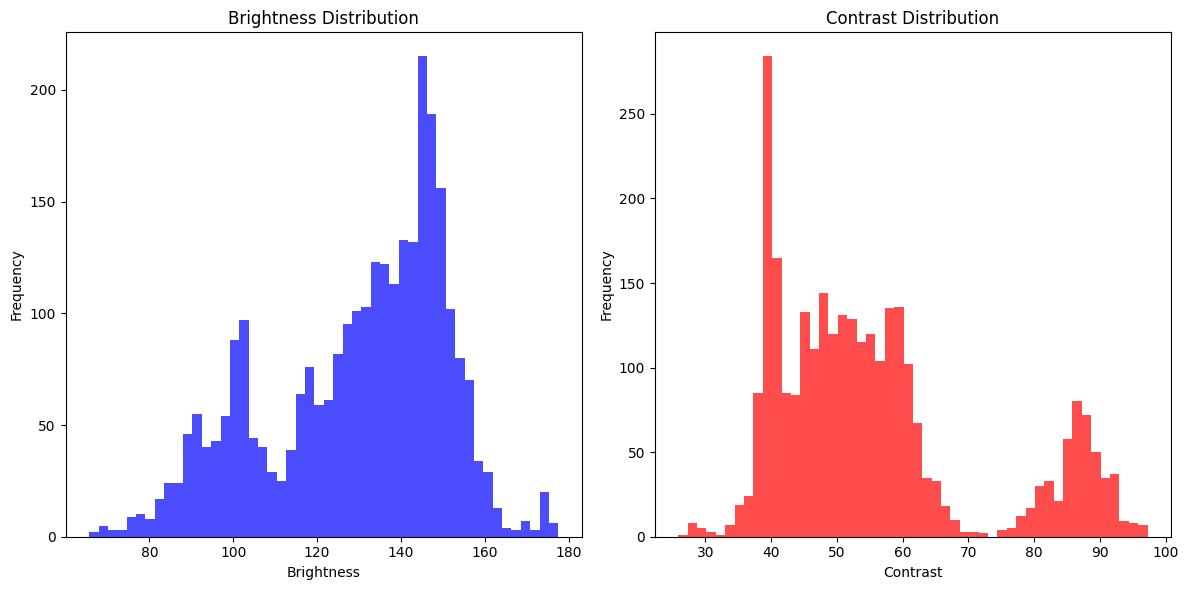

Brightness - mean: 129.60594645689656 std: 21.535287576176813
Contrast   - mean: 55.63252031893593 std: 15.807876849698399


In [26]:
# Analyze brightness and contrast for a sample of images
brightness_list = []
contrast_list = []
sample_size = 100 

for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(class_dir)[:sample_size]:
        img_path = os.path.join(class_dir, img_name)
        brightness, contrast = compute_brightness_contrast(img_path)
        brightness_list.append(brightness)
        contrast_list.append(contrast)

# Plot brightness and contrast
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(brightness_list, bins=50, color='blue', alpha=0.7)
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(contrast_list, bins=50, color='red', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Summary of findings
print("Brightness - mean:", np.mean(brightness_list), "std:", np.std(brightness_list))
print("Contrast   - mean:", np.mean(contrast_list), "std:", np.std(contrast_list))


**Brightness**
- The distribution shows a peak around 145, indicating most images have brightness levels near this value.

**Contrast**
- The distribution shows a range of contrast levels with a prominent peak around 40, indicating moderate levels of contrast in most images.


### Blur Detection

To identify blurred images that may impact model performance.

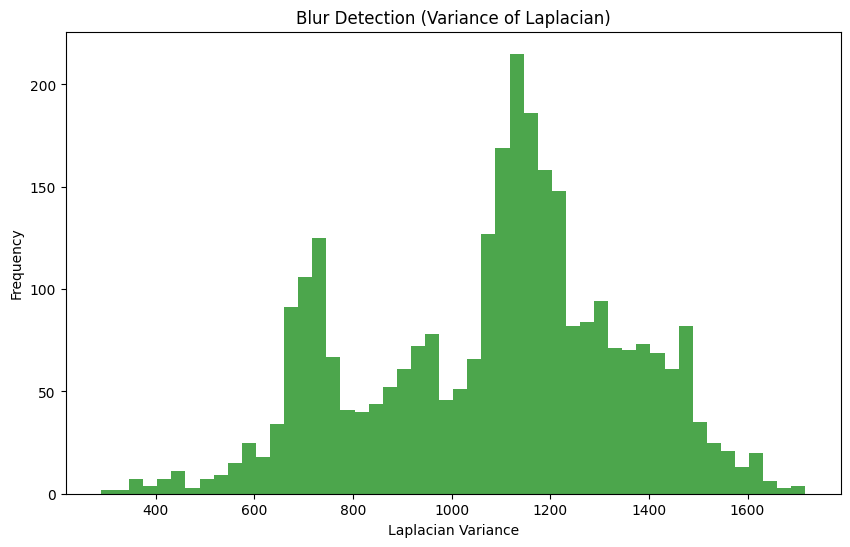

Blur (Laplacian Variance) - mean: 1085.2667423563566 std: 263.9332527813395


In [27]:
def detect_blur(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance


blur_list = []

for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    img_names = os.listdir(class_dir)
    if sample_size:
        img_names = img_names[:sample_size]
    for img_name in img_names:
        img_path = os.path.join(class_dir, img_name)
        blur_variance = detect_blur(img_path)
        blur_list.append(blur_variance)


plt.figure(figsize=(10, 6))
plt.hist(blur_list, bins=50, color='green', alpha=0.7)
plt.title('Blur Detection (Variance of Laplacian)')
plt.xlabel('Laplacian Variance')
plt.ylabel('Frequency')
plt.show()

# Summary of findings
print("Blur (Laplacian Variance) - mean:", np.mean(blur_list), "std:", np.std(blur_list))


The distribution shows a range of sharpness levels, with most images having a variance between 800 and 1400, indicating that the majority of the images are reasonably sharp.


In [31]:
# Summarize findings from image quality checks
print("Summary of Additional Image Quality Checks:")
print(f"Brightness - mean: {np.mean(brightness_list)}, std: {np.std(brightness_list)}")
print(f"Contrast - mean: {np.mean(contrast_list)}, std: {np.std(contrast_list)}")
print(f"Blur (Laplacian Variance) - mean: {np.mean(blur_list)}, std: {np.std(blur_list)}")


Summary of Additional Image Quality Checks:
Brightness - mean: 129.60594645689656, std: 21.535287576176813
Contrast - mean: 55.63252031893593, std: 15.807876849698399
Blur (Laplacian Variance) - mean: 1085.2667423563566, std: 263.9332527813395


Based on the results of the brightness, contrast, and blur detection analyses, dataset appears to have consistent and reasonable image quality. There are no significant outliers or issues that would require extensive preprocessing before model training.